# hex = 8 vs. Hex = 8
1. We need to label the cluster from hex = 8 to hex = 9
2. Using the centroid distance comparison


In [34]:
from sklearn.metrics.pairwise import euclidean_distances
import os
import pandas as pd
import numpy as np
from glob import glob
import gspread
import h3
from tqdm import tqdm
# from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial import distance
import os
cluster_name_7 = {
    0: 'Open-view Connector',
    1: 'Urban Core - Enclosed',
    2: 'Natural Scene-a',
    3: 'Vegetated Community',
    4: 'Urban Core - Open',
    5: 'Diverse Urban Street',
    6: 'Natural Scene-b'
}

In [8]:
ROOTFOLDER = r"D:\Dropbox (Personal)\Personal Work\_Projects2023\01_city-never-was"
DATA_FOLDER = f"{ROOTFOLDER}/_data/_curated/c_seg_hex"
GRAPH_FOLDER = f"{ROOTFOLDER}/_graphic/_supplemental/_raw"
os.listdir(DATA_FOLDER)
# filename = 'c_seg_cat=27_res={res}_withincity_built_environment_tsne_cluster_range.csv'
# df = pd.read_csv(f"{DATA_FOLDER}/{filename}")

['all_city_within_boundary_res=9_cluster=13.csv',
 'all_city_within_boundary_res=9_cluster=13.parquet',
 'all_city_within_boundary_res=9_cluster=8.csv',
 'all_city_within_boundary_res=9_cluster=8.parquet',
 'c_seg_cat=27_res=8.parquet',
 'c_seg_cat=27_res=8_withincity.parquet',
 'c_seg_cat=27_res=8_withincity_built_environment_tsne.parquet',
 'c_seg_cat=27_res=8_withincity_built_environment_tsne_cluster_range.csv',
 'c_seg_cat=27_res=8_withincity_tsne.parquet',
 'c_seg_cat=27_res=9.parquet',
 'c_seg_cat=27_res=9_withincity.parquet',
 'c_seg_cat=27_res=9_withincity_built_environment_tsne.parquet',
 'c_seg_cat=27_res=9_withincity_built_environment_tsne_cluster_range.csv',
 'c_seg_cat=27_res=9_withincity_built_environment_tsne_cluster_range_no_exposure_constrain.csv',
 'c_seg_cat=27_res=9_withincity_tsne.parquet',
 'c_seg_cat=27_res=9_withincity_tsne_cluster_range.csv',
 'version_0717_test']

In [11]:
filename = 'c_seg_cat=27_res={res}_withincity_built_environment_tsne_cluster_range.csv'
raw_file = 'c_seg_cat=27_res={res}_withincity_built_environment_tsne.parquet'
df_8 = pd.read_csv(f"{DATA_FOLDER}/{filename.format(res=8)}")
df_9 = pd.read_csv(f"{DATA_FOLDER}/{filename.format(res=9)}")

df_8_raw = pd.read_parquet(f"{DATA_FOLDER}/{raw_file.format(res=8)}")
df_9_raw = pd.read_parquet(f"{DATA_FOLDER}/{raw_file.format(res=9)}")
df_8_raw.head()

,city_lower,hex_id,img_count,res,tsne_1,tsne_2
0,accra,8875292c81fffff,192,8.0,-26.529926,-26.847006
1,accra,8875292c83fffff,256,8.0,-9.774495,-62.520557
2,accra,8875292c85fffff,112,8.0,-26.428415,-26.569393
3,accra,8875292c87fffff,88,8.0,-10.518588,-65.302887
4,accra,8875292c89fffff,208,8.0,-26.535616,-26.880714


In [28]:
column_sel = 'cluster_7'
df_8_raw_label = df_8_raw.merge(df_8[['hex_id', column_sel]], 
                                on='hex_id', how='inner')
df_9_raw_label = df_9_raw.merge(df_9[['hex_id', column_sel]], 
                                on='hex_id', how='inner')
df_9_raw_label.head()

,city_lower,hex_id,img_count,res,tsne_1,tsne_2,cluster_7
0,accra,8975292c127ffff,20,9.0,32.300644,78.514000,0
1,accra,8975292c803ffff,40,9.0,-80.481400,8.453759,6
2,accra,8975292c80bffff,80,9.0,-32.720524,55.495819,0
3,accra,8975292c817ffff,56,9.0,-38.946735,56.010246,0
4,accra,8975292c81bffff,32,9.0,-38.207615,57.708439,0


In [32]:
# compute the cluster similarity by comparing the cluster centroids
label = 0
dist_dict = {}
all_dist_dict = {}
for label_8 in range(7):
    dist_ls = []
    for label_9 in range(7):
        dist = euclidean_distances(df_8_raw_label[df_8_raw_label[column_sel]==label_8][['tsne_1', 'tsne_2']].mean().values.reshape(1, -1),
                                  df_9_raw_label[df_9_raw_label[column_sel]==label_9][['tsne_1', 'tsne_2']].mean().values.reshape(1, -1))
        dist_ls.append(dist.flatten()[0])
        # all_dist.append(dist.flatten()[0])
        all_dist_dict[(label_8, label_9)] = dist.flatten()[0]
    
    dist_ls = np.array(dist_ls)
    dist_dict[label_8] = np.argmin(dist_ls)
dist_dict


{0: 3, 1: 0, 2: 5, 3: 2, 4: 1, 5: 4, 6: 6}

In [48]:
all_dist_df = pd.DataFrame(all_dist_dict, index=[0]).T.reset_index()
all_dist_df.columns = ['label_8', 'label_9', 'dist']
all_dist_df.head()
all_dist_df['label_9_name'] = all_dist_df['label_9'].apply(lambda x: cluster_name_7[x])
all_dist_df.pivot(index='label_8', columns='label_9_name', values='dist')

label_9_name,Diverse Urban Street,Natural Scene-a,Natural Scene-b,Open-view Connector,Urban Core - Enclosed,Urban Core - Open,Vegetated Community
label_8,,,,,,,
0,70.036911,69.844574,76.745827,69.090363,75.190971,73.733322,0.933713
1,137.800537,112.076271,62.276661,12.732536,126.805191,84.431679,68.440826
2,8.471956,88.648376,137.259308,138.473633,59.644215,110.782112,70.297287
3,67.580589,16.558310,86.623108,127.944527,120.964478,142.671066,70.483063
4,84.995590,134.548767,144.794647,103.567352,24.643679,40.819527,70.371552
5,123.110931,137.009766,115.493248,51.472980,83.048622,23.558268,68.453911
6,121.262764,55.817013,16.377247,84.086189,146.638596,134.808151,72.653145


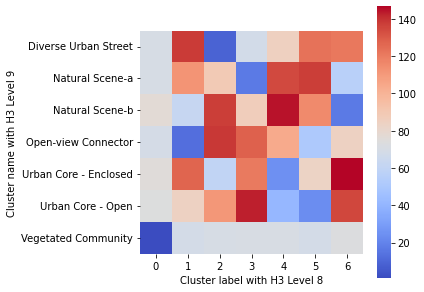

In [49]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(all_dist_df.pivot(columns='label_8', index='label_9_name', values='dist'), annot=False, cmap='coolwarm', square=True)
ax.set_xlabel('Cluster label with H3 Level 8')
ax.set_ylabel('Cluster name with H3 Level 9')
plt.savefig(f"{GRAPH_FOLDER}/cluster_similarity_h3_8_9.png", dpi=300, bbox_inches='tight')

## revisualize the cluster attirbutes

In [70]:
variables_sel_top1_order = [
    'skyscraper',

 'light',
   'pole',
    "road",
 'sidewalk', 
  'traffic light', 
     # nature and open space
      "building",
      "railing",
    'window',
    'trashcan',
         'installation', 
         
    'signage',
    'grass',
    'shrub', 
    'tree',
    
     'mountain+hill',
    
    'sportsfield',
    'sky',
    'lake+waterboday',
]

In [71]:
N = 7
df_summary = df_8[variables_sel_top1_order+[f"cluster_{N}"]].groupby(f"cluster_{N}").mean().stack().reset_index()\
.rename(columns = {"level_1":"category", 0:"std_value"})


df_summary_update = []
for v in df_summary["category"].unique():
    temp = df_summary[df_summary["category"]==v].reset_index(drop = True)
    temp["norm_value"] = (temp["std_value"] - temp["std_value"].min())/(temp["std_value"].max() - temp["std_value"].min())
    df_summary_update.append(temp)
    
df_summary_update = pd.concat(df_summary_update).reset_index()


df_heat = df_summary_update.pivot(
    columns= "category", values = "norm_value", index = f"cluster_{N}"
)[variables_sel_top1_order].sort_values(variables_sel_top1_order[:5], ascending = False)
df_heat


category,skyscraper,light,pole,road,sidewalk,traffic light,building,railing,window,trashcan,installation,signage,grass,shrub,tree,mountain+hill,sportsfield,sky,lake+waterboday
cluster_7,,,,,,,,,,,,,,,,,,,
4,1.000000,0.993994,0.515537,0.831348,1.000000,1.000000,0.720004,0.249649,0.153074,0.212369,0.213619,0.508217,0.060438,0.000000,0.142012,0.017414,0.000000,0.149148,0.001601
2,0.384447,0.643959,1.000000,0.493464,0.686584,0.231263,1.000000,0.582331,1.000000,0.247370,1.000000,1.000000,0.000000,0.336559,0.221001,0.011320,0.017599,0.000000,0.097816
0,0.261089,1.000000,0.192532,1.000000,0.324554,0.147209,0.241416,1.000000,0.054597,0.093753,0.054173,0.502073,0.148881,0.073864,0.000000,0.164244,0.244136,1.000000,0.084373
5,0.245995,0.706339,0.070887,0.895868,0.946799,0.490663,0.323546,0.459718,0.031779,1.000000,0.081177,0.333462,0.324970,0.462586,0.545834,0.000000,0.021801,0.406929,0.000000
1,0.091501,0.426667,0.070356,0.934612,0.392383,0.152385,0.088489,0.201972,0.002544,0.238201,0.009451,0.191353,1.000000,0.318371,1.000000,0.021204,0.272072,0.631915,0.053791
6,0.014259,0.000000,0.000000,0.257118,0.000000,0.000000,0.000000,0.066341,0.000000,0.000000,0.000000,0.000000,0.245487,1.000000,0.993361,1.000000,1.000000,0.536866,0.208120
3,0.000000,0.167280,0.261142,0.000000,0.078474,0.002905,0.247578,0.000000,0.065800,0.003596,0.216882,0.073535,0.135923,0.374218,0.381292,0.146181,0.402961,0.911138,1.000000


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 1, 'skyscraper'),
  Text(1.5, 1, 'light'),
  Text(2.5, 1, 'pole'),
  Text(3.5, 1, 'road'),
  Text(4.5, 1, 'sidewalk'),
  Text(5.5, 1, 'traffic light'),
  Text(6.5, 1, 'building'),
  Text(7.5, 1, 'railing'),
  Text(8.5, 1, 'window'),
  Text(9.5, 1, 'trashcan'),
  Text(10.5, 1, 'installation'),
  Text(11.5, 1, 'signage'),
  Text(12.5, 1, 'grass'),
  Text(13.5, 1, 'shrub'),
  Text(14.5, 1, 'tree'),
  Text(15.5, 1, 'mountain+hill'),
  Text(16.5, 1, 'sportsfield'),
  Text(17.5, 1, 'sky'),
  Text(18.5, 1, 'lake+waterboday')])

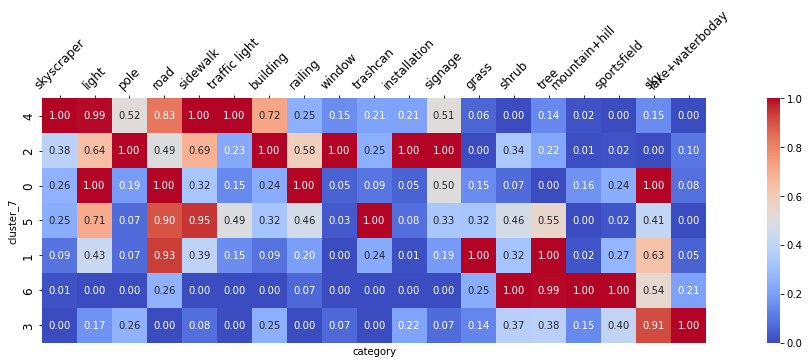

In [72]:
# use heatmap to visualize the cluster
fig, ax = plt.subplots(figsize = (22,4.5))
# use a gradient color
# cluster_order = [0,5,3,6,2,1,7,4]
sns.heatmap(df_heat, 
            cmap = "coolwarm", annot = True, fmt=".2f",
            square = True, 
            ax = ax)
# show axis annotation larger
ax.tick_params(axis='both', which='major', labelsize=12)
# show ticks to the left
ax.yaxis.tick_left()
# show ticks to the bottom
ax.xaxis.tick_top()
# rotate the x axis
plt.xticks(rotation=45)

In [80]:
h3_8_mapping = {
    4: 'Urban Core - Open',
    2:"Urban Core - Enclosed",
    0: 'Diverse Urban Street',
    5: 'Vegetated Community',
    1: 'Open-view Connector',
    6: 'Natural Scene-a',
    3: 'Natural Scene-b'
}

In [84]:
df_8_raw_label.groupby(['city_lower'])['hex_id'].count().reset_index().sort_values('hex_id', ascending=False)

,city_lower,hex_id
46,jaipur,3283
4,athens,2294
63,london,2193
60,lagos,1883
45,istanbul,1867
...,...,...
21,cirebon,72
103,santiago,50
110,sydney,48
119,victoria,44


In [81]:
df_8_raw_label['cluster_7_mapped'] = df_8_raw_label['cluster_7'].map(h3_8_mapping)
df_8_city = df_8_raw_label.groupby(['city_lower','cluster_7_mapped'])['hex_id'].count().unstack().fillna(0)
df_8_city['robustness_type'] = 'h3'

df_8_city.to_csv(os.path.join(DATA_FOLDER, 'robustness_h3_8.csv'), index=True)

os.listdir(DATA_FOLDER)